In [54]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [2]:
# !pip uninstall numba
# !pip install --upgrade numba

In [3]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

In [55]:
df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)

In [57]:
df = df.head(100)
threshold = 10
column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) >= 10]
print(len(column_list))

269


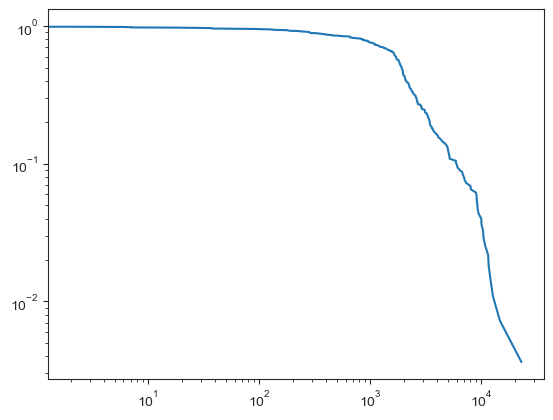

(array([22., 19.,  9., 10., 15., 11., 13., 29., 34., 17., 11., 12.,  6.,
         4., 11.,  4.,  4.,  3.,  1.,  2.,  2.,  4.,  4.,  0.,  0.,  2.,
         2.,  1.,  0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         3.,  2.,  1.,  0.,  2.,  0.,  2.,  0.,  1.,  0.,  0.,  2.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([    0. ,   230.3,   460.6,   690.9,   921.2,  1151.5,  1381.8,
         1612.1,  1842.4,  2072.7,  2303. ,  2533.3,  2763.6,  2993.9,
         3224.2,  3454.5,  3684.8,  3915.1,  4145.4,  4375.7,  4606. ,
         4836.3,  5066.6,  5296.9,  5527.2,  5757.5,  5987.8,  6218.1,
         6448.4,  6678.7,  6909. ,  7139.3,  7369.6,  7599.9,  7830.2,
         8060.5,  8290.8,  8521.1,  8751.4,  8981.7,  9212. ,  9442.3,
        

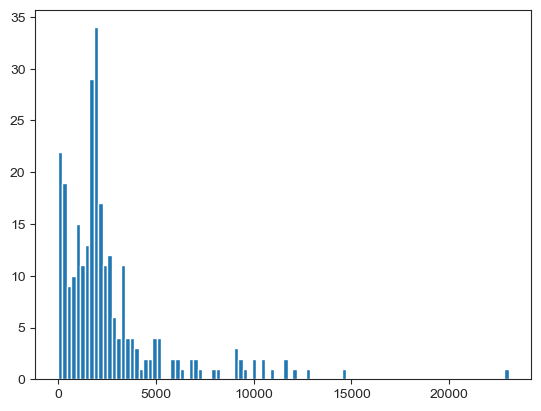

In [7]:
counts = [sum(df[col]) for col in df.columns[1:]]
counts.sort()
ccdf = 1.0 - np.arange(len(counts)) / len(counts)
plt.plot(counts, ccdf)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.hist(counts, bins=100)
# for col in df.columns[1:]:
#     if sum(df[col]) < 10:
#         print(col)
#         print(sum(df[col]))

We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^iB_j$$
$$P\left(Y_i\right)=\text{logit}\left(Z_i\right)$$
$$B_j\sim N\left(0,\sigma\right)$$
$$\sigma=1$$

In [6]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [58]:

# # Option 1: normalize by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
# X = np.array([df[col]*10/sum(df[col]) for col in column_list])
# print(len(X))

# Option 2: normalize using z-score method:
X = np.array([sp.stats.zscore(df[col]) for col in column_list])

Y = []
for col in column_list:
    Y.append(meta_df[meta_df['ROI']==col]['diagnosis'].values[0])

print(len(Y))
print(X)

269
[[ 8.71880411 -0.40432952 -0.09375476 ... -0.26845306  0.08094355
  -0.21022029]
 [ 8.20810743 -0.18260107 -0.28576552 ... -0.38892997  0.19566857
  -0.01066033]
 [ 7.88050697 -0.59150013 -0.2064089  ... -0.43746364 -0.12939065
   0.21719145]
 ...
 [ 0.08794091 -0.20730435 -0.03859277 ... -0.16512646 -0.23893777
  -0.27057119]
 [ 7.82891365  0.17063189 -0.36679139 ... -0.23243557 -0.50114721
  -0.36679139]
 [ 5.14868532 -0.23947374 -0.53881591 ... -0.43903518 -0.03991229
  -0.23947374]]


In [59]:
model = stan.build(model_code, data={'N': len(X), 'q': len(df), 'X': X, 'Y': Y})

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 13, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will 

In [60]:
fit = model.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [61]:
fit_az = arviz.from_pystan(fit)
arviz.summary(fit_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.979,0.935,-0.750,2.733,0.012,0.012,6538.0,3030.0,1.0
beta[0],-0.087,0.170,-0.411,0.220,0.003,0.002,4153.0,3586.0,1.0
beta[1],-0.726,0.821,-2.183,0.851,0.010,0.010,7135.0,2717.0,1.0
beta[2],-0.743,0.750,-2.121,0.669,0.009,0.009,6617.0,3156.0,1.0
beta[3],1.085,0.818,-0.394,2.688,0.010,0.009,7059.0,3172.0,1.0
...,...,...,...,...,...,...,...,...,...
z[264],15.043,2.638,10.275,20.162,0.036,0.026,5402.0,3546.0,1.0
z[265],15.079,3.338,8.862,21.475,0.043,0.032,5923.0,3489.0,1.0
z[266],1.884,0.747,0.475,3.285,0.010,0.008,5798.0,3019.0,1.0
z[267],4.728,2.172,0.654,8.663,0.027,0.021,6748.0,3608.0,1.0


In [45]:
az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
plt.tight_layout()

NameError: name 'az' is not defined

In [62]:
# any diverging transitions?
print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

Number of diverging samples: 0.0


In [47]:
print(fit)

<stan.Fit>
Parameters:
    alpha: ()
    beta: (1000,)
    z: (272,)
Draws: 4000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


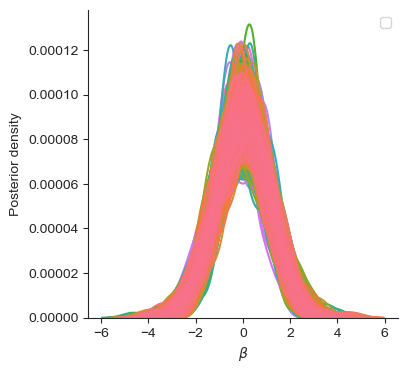

In [63]:
# posterior of z
plt.figure(figsize=(4, 4))
sns.kdeplot(fit['beta'][:])
plt.xlabel(r"$\beta$")
plt.ylabel("Posterior density")
sns.despine()
plt.legend()

Text(0.5, 0, '$Y$')

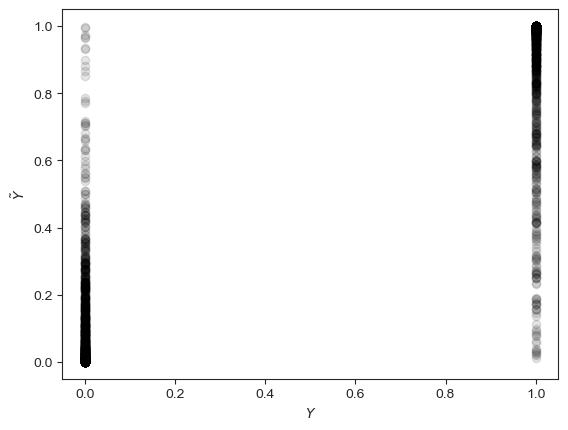

In [64]:
# viz_scatter()
from sklearn.metrics import confusion_matrix
import random

correct_guesses = 0
total_guesses = 0
# add simulated data points
for i in range(10):
    idx = np.random.randint(0, 4000)
    scaled = [fit['beta'][:, idx] * x[:] for x in X]
    z = [fit['alpha'][0, idx] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
#     r = [random.random() for _ in range(len(Y_tilde))]
#     correct_guesses += len(r[r < Y_tilde])
#     total_guesses += len(r)

# print(correct_guesses / total_guesses)

plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# sns.despine()